In [1]:
import torch
cuda_available = torch.cuda.is_available()
print(f"CUDA доступен: {cuda_available}")

CUDA доступен: False


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import os
from pathlib import Path
import json
import xarray

In [3]:
sys.path.append(str(Path.cwd().parent))

In [4]:
from models.weathUNet import create_weather_unet
from data.dataset import ERA5DownscalingDataset
from training.trainer import DownscalingTrainer
from training.metrics import MetricLogger
from training.losses import CombinedLoss

In [5]:
from train import setup_topography, create_model, create_dataloaders, evaluate_on_test_set
config = {
    'data_path': '/Users/diana/Downloads/era5_downscaling/world',
    'years': [2021],
    'variables': ['T2M', '10u', '10v', 'MSL', 'TP'],  
    'model_type': 'unet',
    'hidden_dim': 32,
    'scale_factor': 4,
    'downscale_method': 'avg_pool',
    'batch_size': 4,
    'epochs': 10,
    'lr': 1e-4,
    'weight_decay': 1e-5,
    'use_topography': True,
    'experiment_name': 'surface',
    'resume': None,
    'stats_file': '../../main_phys_downscaling_code/json_stats.nc'
}

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [7]:
dataset = ERA5DownscalingDataset(
    data_path=config['data_path'],
    years_to_process=config['years'],
    variables_to_load=config['variables'],
    scale_factor=config['scale_factor'],
    normalize=True,
    stats_file_path=config['stats_file'],
    downscale_method=config['downscale_method'],
    cache_size=200,
    time_chunk_size=1
)

Initializing optimized ERA5 dataset...
Loading data from: /Users/diana/Downloads/era5_downscaling/world/2021-08-01_2021-08-22.zarr
Using variables: ['T2M', 'MSL', 'TP']
High resolution: (721, 1440), Low resolution: (180, 360)
Total timesteps: 22
Cache size: 200, Precompute low-res: True


In [8]:
dataset_info = dataset.get_dataset_info()
print(f"Датасет создан: {len(dataset)} samples")

Датасет создан: 22 samples


In [9]:
sample = dataset[0]
print(f"Пример данных:")
print(f"  Input shape: {sample['input'].shape}")
print(f"  Target shape: {sample['target'].shape}")
print(f"  Input size in MB: {sample['input'].numel() * 4 / 1024 / 1024:.2f}")
print(f"  Target size in MB: {sample['target'].numel() * 4 / 1024 / 1024:.2f}")

Пример данных:
  Input shape: torch.Size([3, 180, 360])
  Target shape: torch.Size([3, 721, 1440])
  Input size in MB: 0.74
  Target size in MB: 11.88


In [10]:
dataloaders = create_dataloaders(
    dataset,
    batch_size=config['batch_size'],
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)

Разделение данных: Train 15, Val 3, Test 4


In [8]:
from data.dataset import OptimizedDataLoader
dataloaders = OptimizedDataLoader.create_dataloaders(
    dataset,
    batch_size=config['batch_size'],
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)

Dataset split: Train 15, Val 3, Test 4


In [9]:
topography = None

if config['use_topography']:
    sample_item = dataset[0]
    low_res_shape = sample_item['input'].shape[-2:]
    topography = setup_topography(low_res_shape)
    
    topography_mean = topography.mean()
    topography_std = topography.std()
    topography = (topography - topography_mean) / topography_std
    
    print(f"Топография нормализована: mean={topography_mean:.2f}, std={topography_std:.2f}")
    print(f"После нормализации: min={topography.min():.4f}, max={topography.max():.4f}")
    
    if topography.dim() == 2:
        topography = topography.unsqueeze(0)

Топография загружена из /Users/diana/Downloads/save_archive/topography_721x1440.pt, форма: torch.Size([1, 1, 721, 1440])
Топография после squeeze: torch.Size([721, 1440])
Ресайз топографии torch.Size([721, 1440]) -> torch.Size([180, 360])
Финальная форма топографии: torch.Size([180, 360])
Топография нормализована: mean=375.91, std=849.80
После нормализации: min=-0.4435, max=6.1857


In [13]:
# model = create_weather_unet(
#         model_type='unet',
#         in_chans=4,
#         out_chans=3,
#         hidden_dim=64,
#         scale_factor=4
#     ).to(device)

# Получите реальное количество каналов из данных
sample = dataset[0]
num_input_channels = sample['input'].shape[0]
num_output_channels = sample['target'].shape[0]

model = create_weather_unet(
    model_type='unet',
    in_chans=num_input_channels,  
    out_chans=num_output_channels,  
    hidden_dim=64,
    scale_factor=4
).to(device)

print(f"Создана модель с {num_input_channels} входными и {num_output_channels} выходными каналами")

Создана модель с 3 входными и 3 выходными каналами


In [14]:
print(model.__class__.__name__)

WeatherUNet


In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Модель создана. Параметров: {total_params:,}")

Модель создана. Параметров: 9,250,959


In [16]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['lr'], 
    weight_decay=config['weight_decay']
)

In [17]:
criterion = nn.MSELoss()

In [18]:
trainer = DownscalingTrainer(
    model=model,
    train_loader=dataloaders['train'],
    val_loader=dataloaders['val'],
    optimizer=optimizer,
    device=device,
    experiment_name=config['experiment_name'],
    criterion=criterion,
    use_topography=config['use_topography'],
    topography_data=topography
)

print(f"Начало обучения на {config['epochs']} эпох...")
trainer.train(num_epochs=config['epochs'])

Инициализирован тренер для surface
Модель: WeatherUNet
Устройство: cpu
Использование топографии: True
Размер train_loader: 4
Размер val_loader: 1
Начало обучения на 10 эпох...
Начало обучения на 10 эпох
Размер train_loader: 4 батчей
Размер val_loader: 1 батчей
Проверка совместимости размеров...
Input shape: torch.Size([4, 3, 180, 360])
Target shape: torch.Size([4, 3, 721, 1440])
Topography shape: torch.Size([4, 1, 180, 360])
Model output shape: torch.Size([4, 3, 721, 1440])

--- Epoch 1/10 ---
  Train Batch 0/4, Loss: 3.853577
  Train Batch 1/4, Loss: 3.843188
  Train Batch 2/4, Loss: 3.850955
  Train Batch 3/4, Loss: 3.829637
  Val Batch 0/1, Loss: 3.062315
Метрики эпохи 0 сохранены
Checkpoint сохранен: checkpoints/best_model.pth
Новая лучшая модель! Val Loss: 3.062315
Checkpoint сохранен: checkpoints/checkpoint_epoch_0.pth
Epoch 1 завершена за 4.67 сек
Train Loss: 3.844339, Val Loss: 3.062315
Train MAE: 1.5859, Val MAE: 1.4442

--- Epoch 2/10 ---
  Train Batch 0/4, Loss: 3.820946
  T

In [19]:
model_dir = Path('models')
model_dir.mkdir(exist_ok=True)
model_path = model_dir / f"{config['experiment_name']}_final.pth"
torch.save(model.state_dict(), model_path)

In [22]:
import numpy as np
sample = dataset[0]
print(f"Input - min: {sample['input'].min():.4f}, max: {sample['input'].max():.4f}, mean: {sample['input'].mean():.4f}, std: {sample['input'].std():.4f}")
print(f"Target - min: {sample['target'].min():.4f}, max: {sample['target'].max():.4f}, mean: {sample['target'].mean():.4f}, std: {sample['target'].std():.4f}")
if config['use_topography']:
    print(f"Topography - min: {topography.min():.4f}, max: {topography.max():.4f}, mean: {topography.mean():.4f}, std: {topography.std():.4f}")

Input - min: -3.0000, max: 6.6476, mean: -0.2047, std: 1.9540
Target - min: -3.0000, max: 12.2360, mean: -0.2060, std: 1.9554
Topography - min: -0.4435, max: 6.1857, mean: 0.0000, std: 1.0000


In [10]:
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

sys.path.append(str(Path.cwd().parent))

test_results_dir = Path('test_results')
test_results_dir.mkdir(exist_ok=True, parents=True)

In [11]:
from models.weathUNet import load_trained_model
checkpoint_path = Path('../scripts/checkpoints/best_model.pth')
if not checkpoint_path.exists():
    checkpoint_path = Path('../scripts/checkpoints/final_model.pth')


In [12]:
model_kwargs = {
    'model_type': 'unet',
    'in_chans': 3,  # T2M, MSL, TP
    'out_chans': 3,
    'hidden_dim': 64,
    'scale_factor': 4
}

from models.weathUNet import create_weather_unet
model = create_weather_unet(**model_kwargs)
model = load_trained_model(checkpoint_path, create_weather_unet, model_kwargs, device)

Загрузка модели из ../scripts/checkpoints/best_model.pth
Загружен model_state_dict из checkpoint
Модель загружена и перемещена на cpu
Архитектура: WeatherUNet


In [13]:
sample = dataset[0]
real_num_channels = sample['input'].shape[0]

if len(config['variables']) >= real_num_channels:
    actual_variables = config['variables'][:real_num_channels]
else:
    actual_variables = [f'channel_{i}' for i in range(real_num_channels)]

print(f"Количество каналов в данных: {real_num_channels}")
print(f"Используемые переменные: {actual_variables}")

Количество каналов в данных: 3
Используемые переменные: ['T2M', '10u', '10v']


In [ ]:
from test_functions import SpatialDownscalingTester
# tester = SpatialDownscalingTester(
#     model=model,
#     device=device,
#     use_topography=config['use_topography'],
#     topography_data=topography,
#     variable_names=actual_variables  
# )
tester = SpatialDownscalingTester(
    model=model,
    device=device,
    use_topography=config['use_topography'],
    topography_data=topography,
    variable_names=actual_variables,  
    fs=1.0  
)

Инициализирован тестер. Результаты будут сохранены в: test_results/20251207_133222


Начало тестирования на 4 сэмплах...


Тестирование: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]



Формы данных:
  Inputs: (4, 3, 180, 360)
  Targets: (4, 3, 721, 1440)
  Predictions: (4, 3, 721, 1440)

Вычисление всесторонних метрик...
Глобальные метрики вычислены

T2M:
  MSE: 1.3744
  RMSE: 0.9453
  MAE: 0.9292
  Bias: -0.3698

10u:
  MSE: 0.6998
  RMSE: 0.7893
  MAE: 0.7718
  Bias: -0.4928

10v:
  MSE: 7.1829
  RMSE: 2.6726
  MAE: 2.6637
  Bias: 2.6581

Сохранение пространственных метрик в Zarr...
Сохраняем метрики для переменных: ['T2M', '10u', '10v']
Пространственные метрики сохранены в: test_results/20251207_133222/spatial_metrics.zarr

Визуализация всех метрик...

Визуализация пространственных метрик...


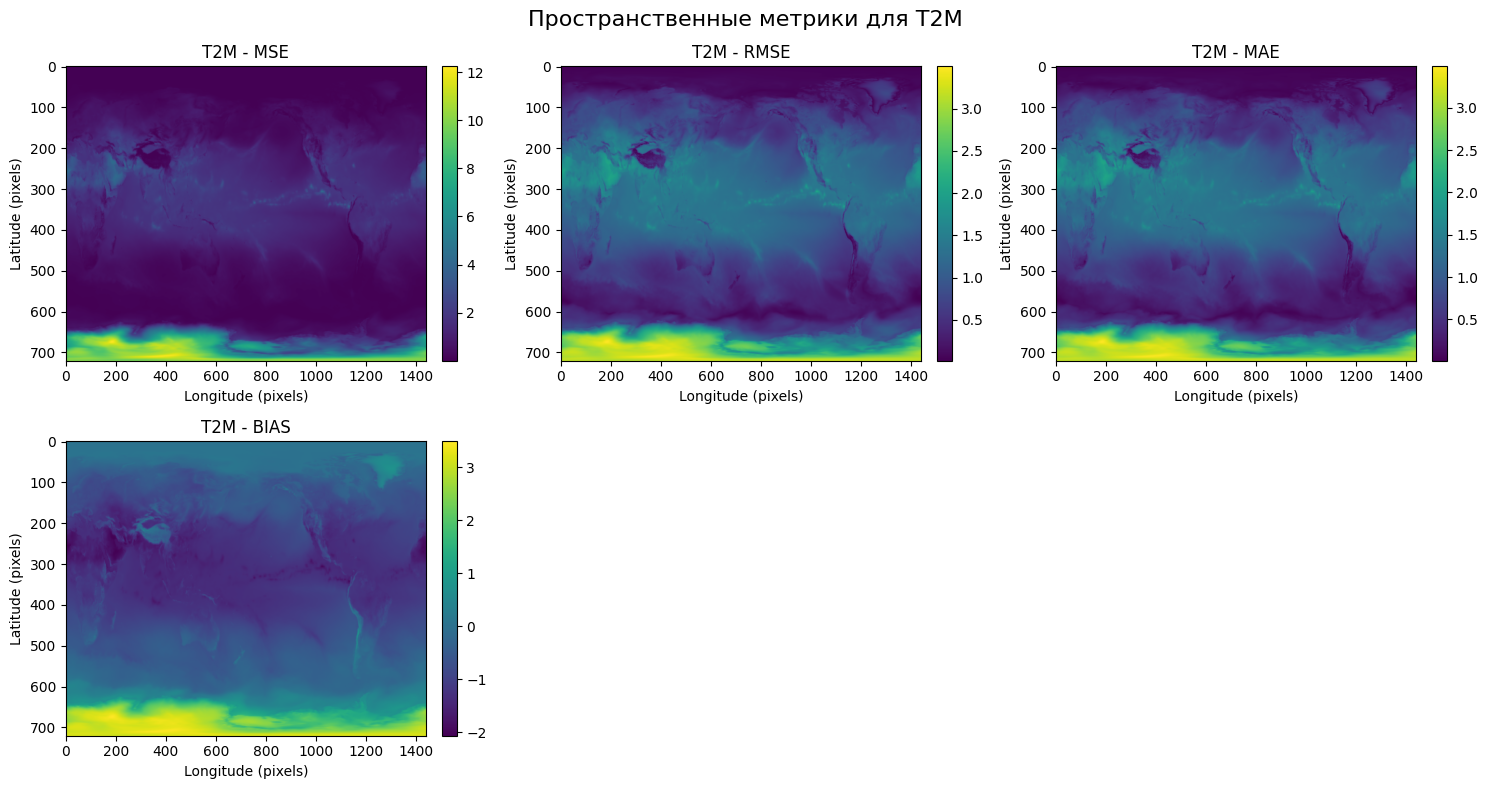

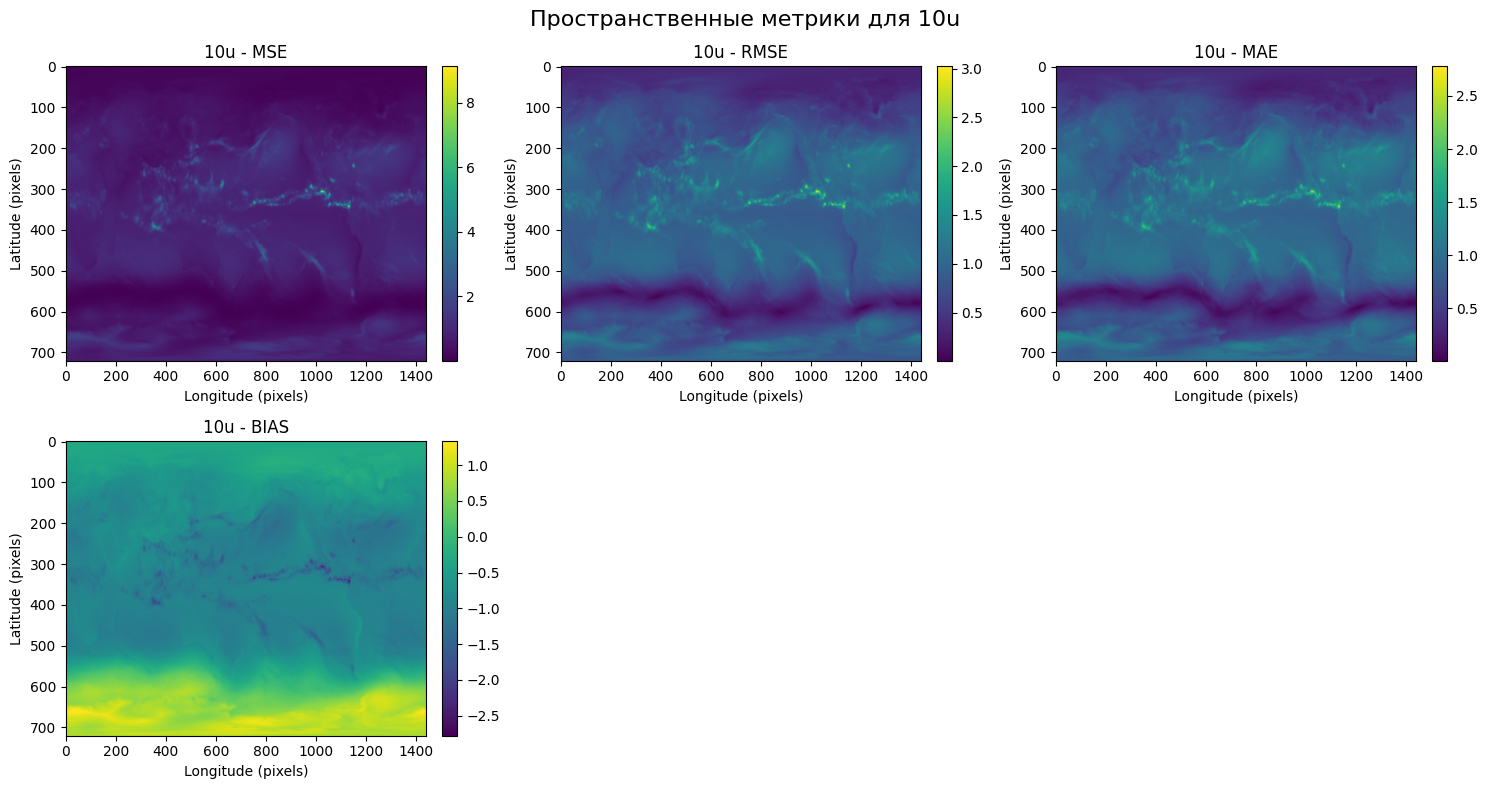

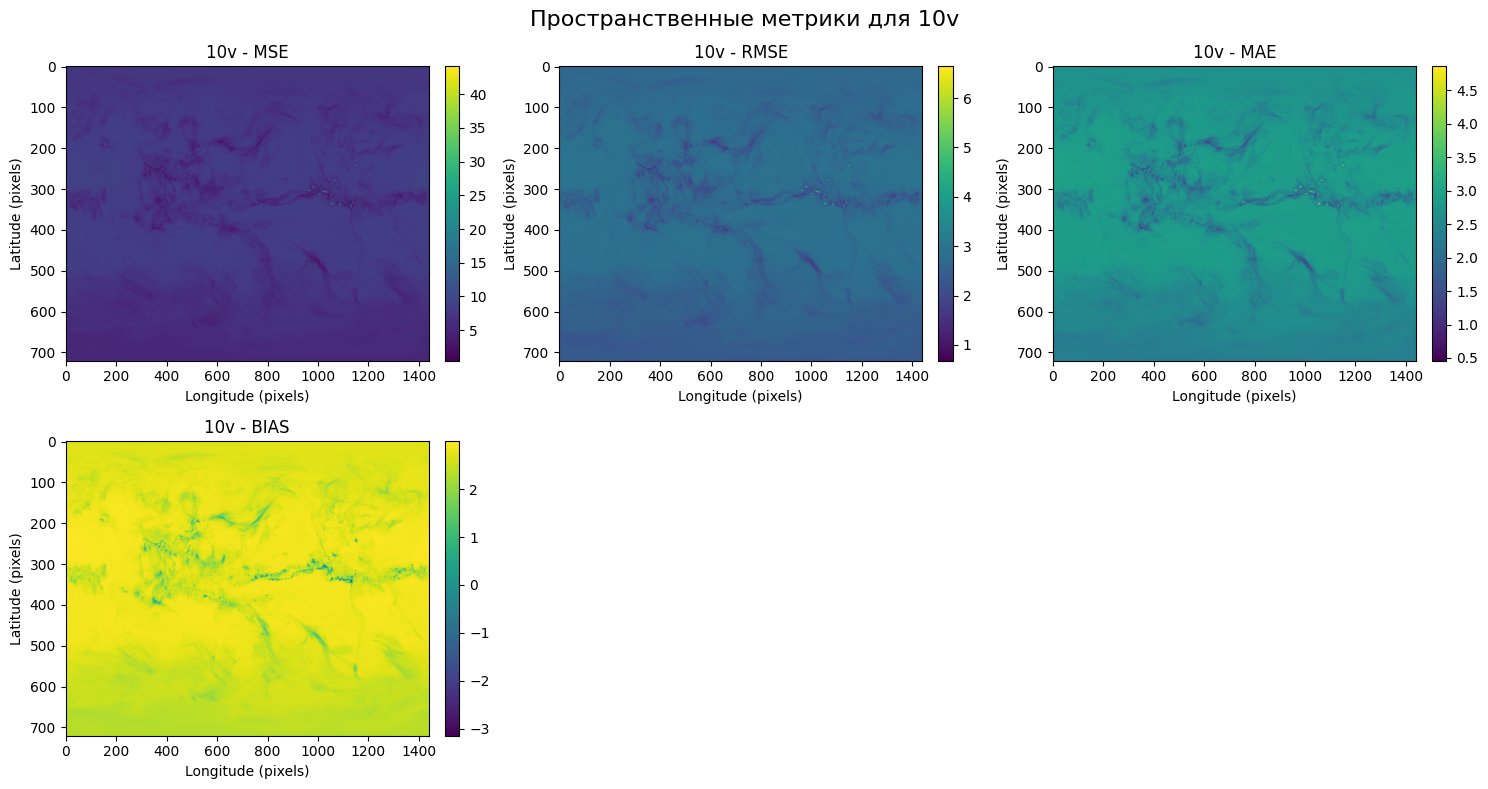


Визуализация спектральных метрик...


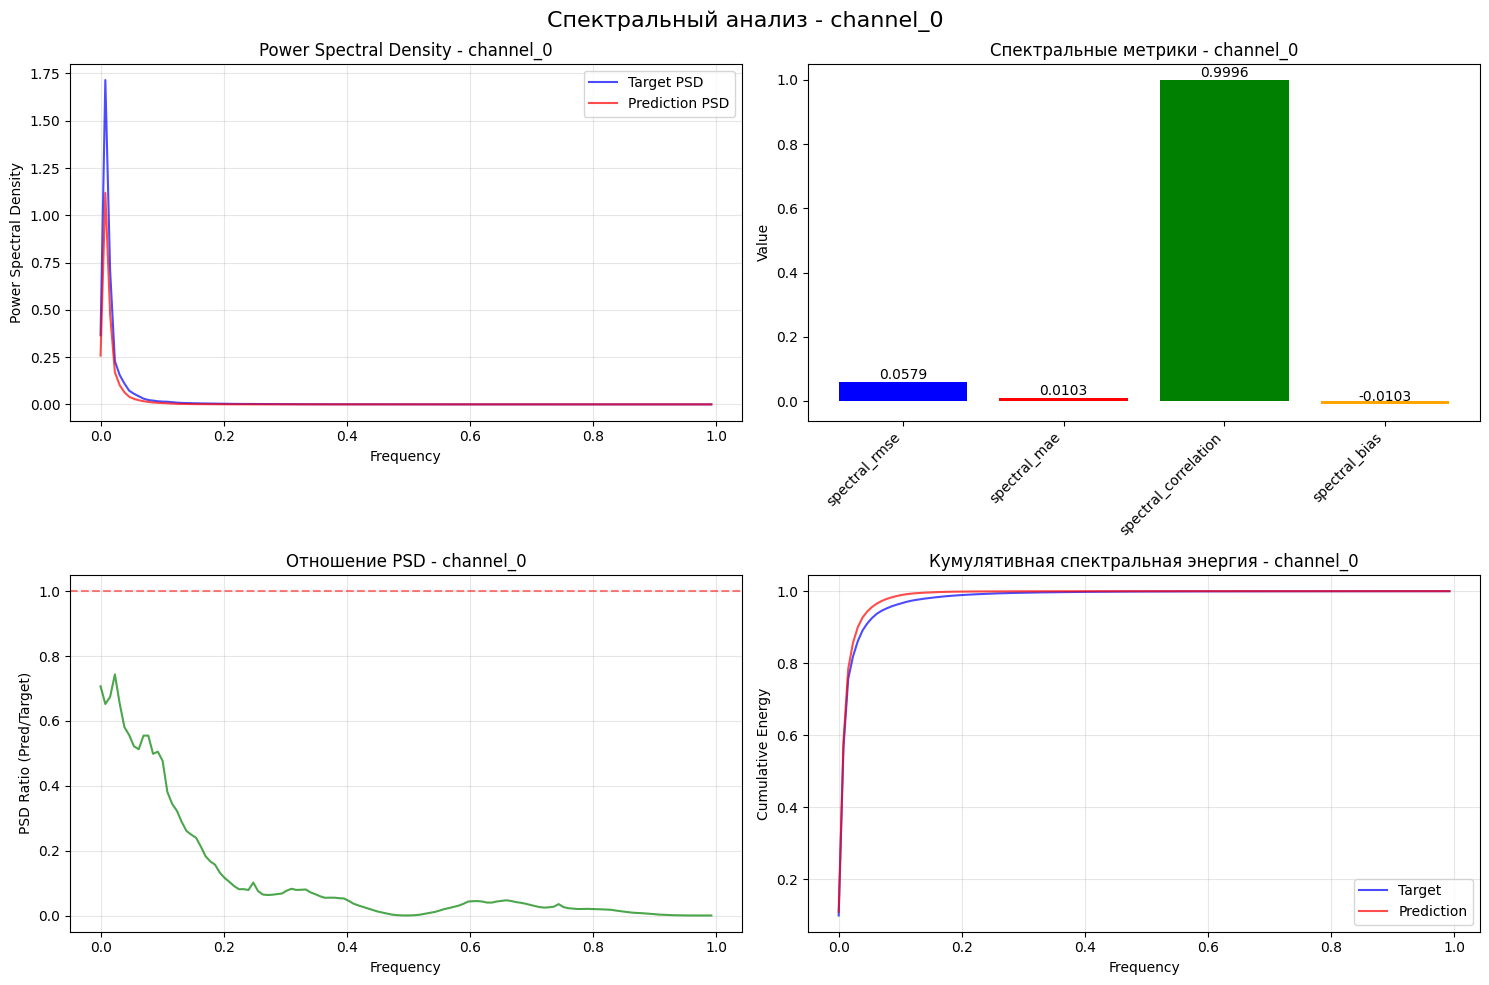

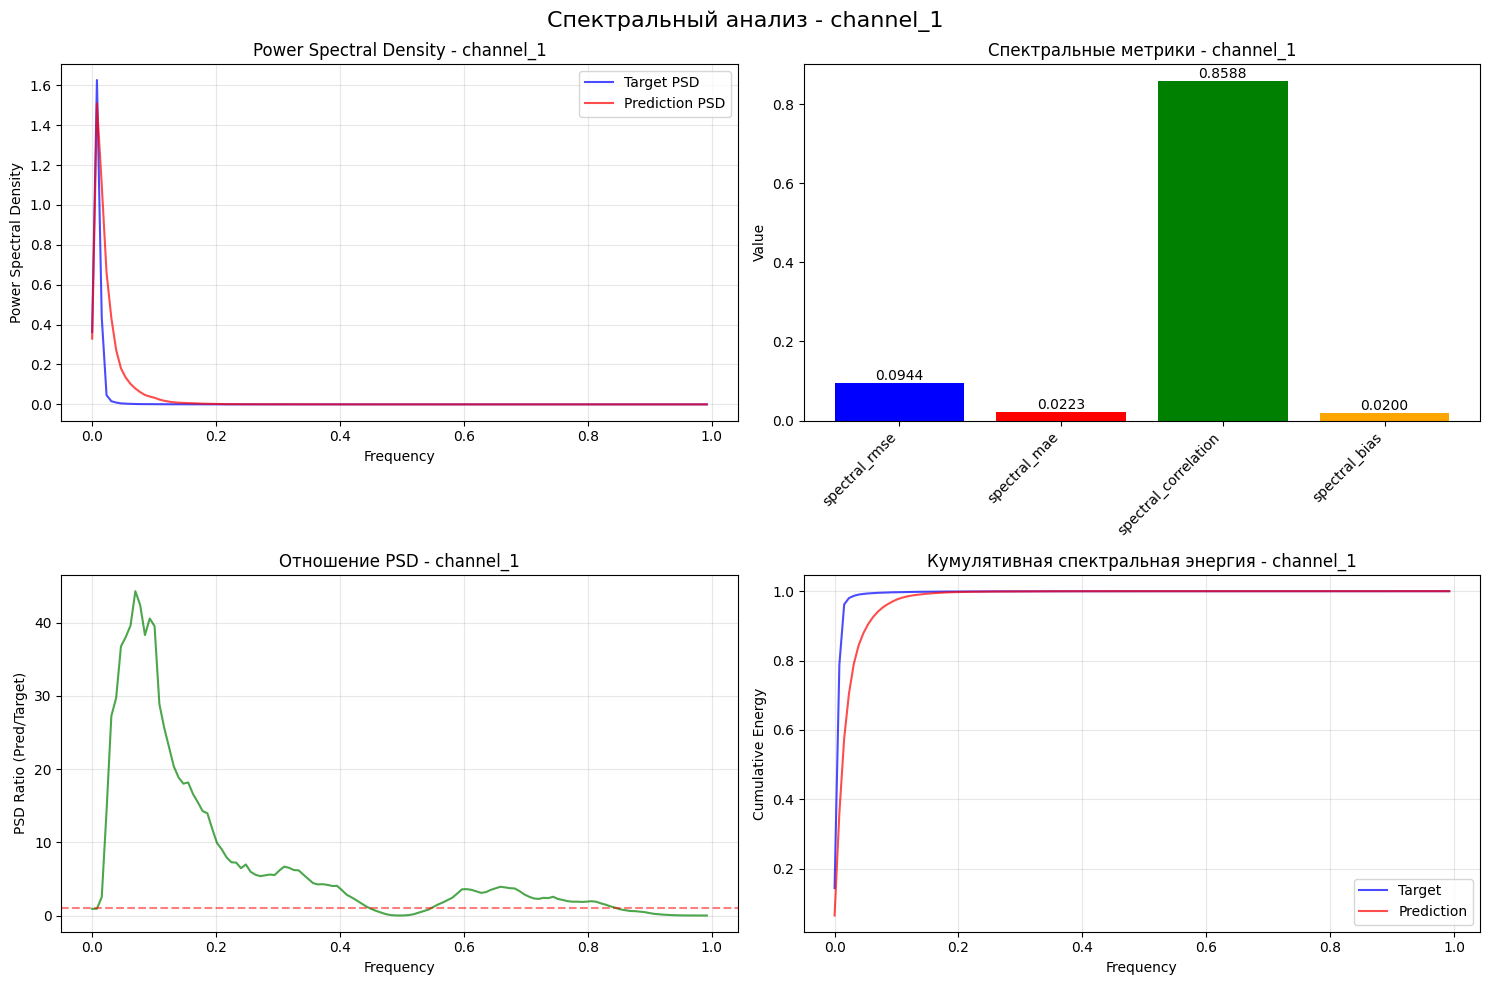

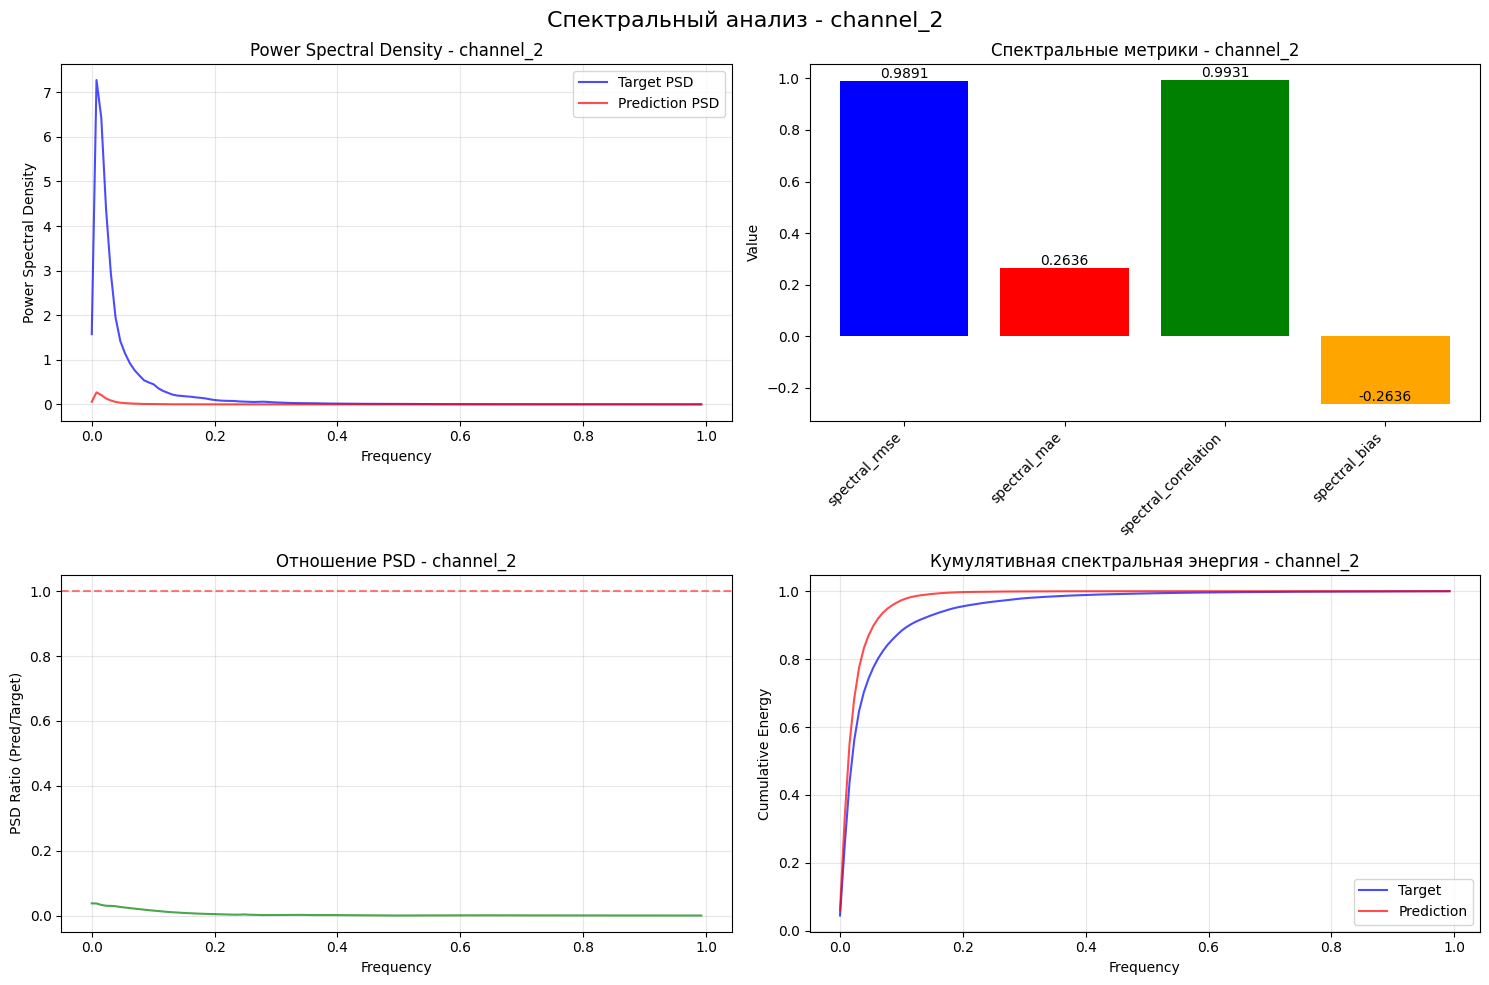


Визуализация Energy Spectra...


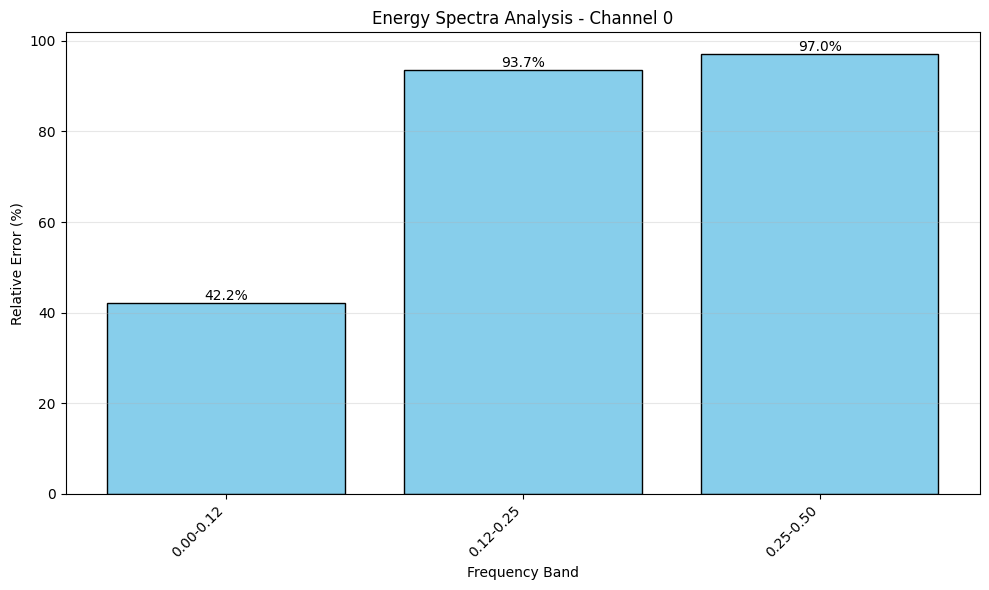


Создание сводной визуализации...


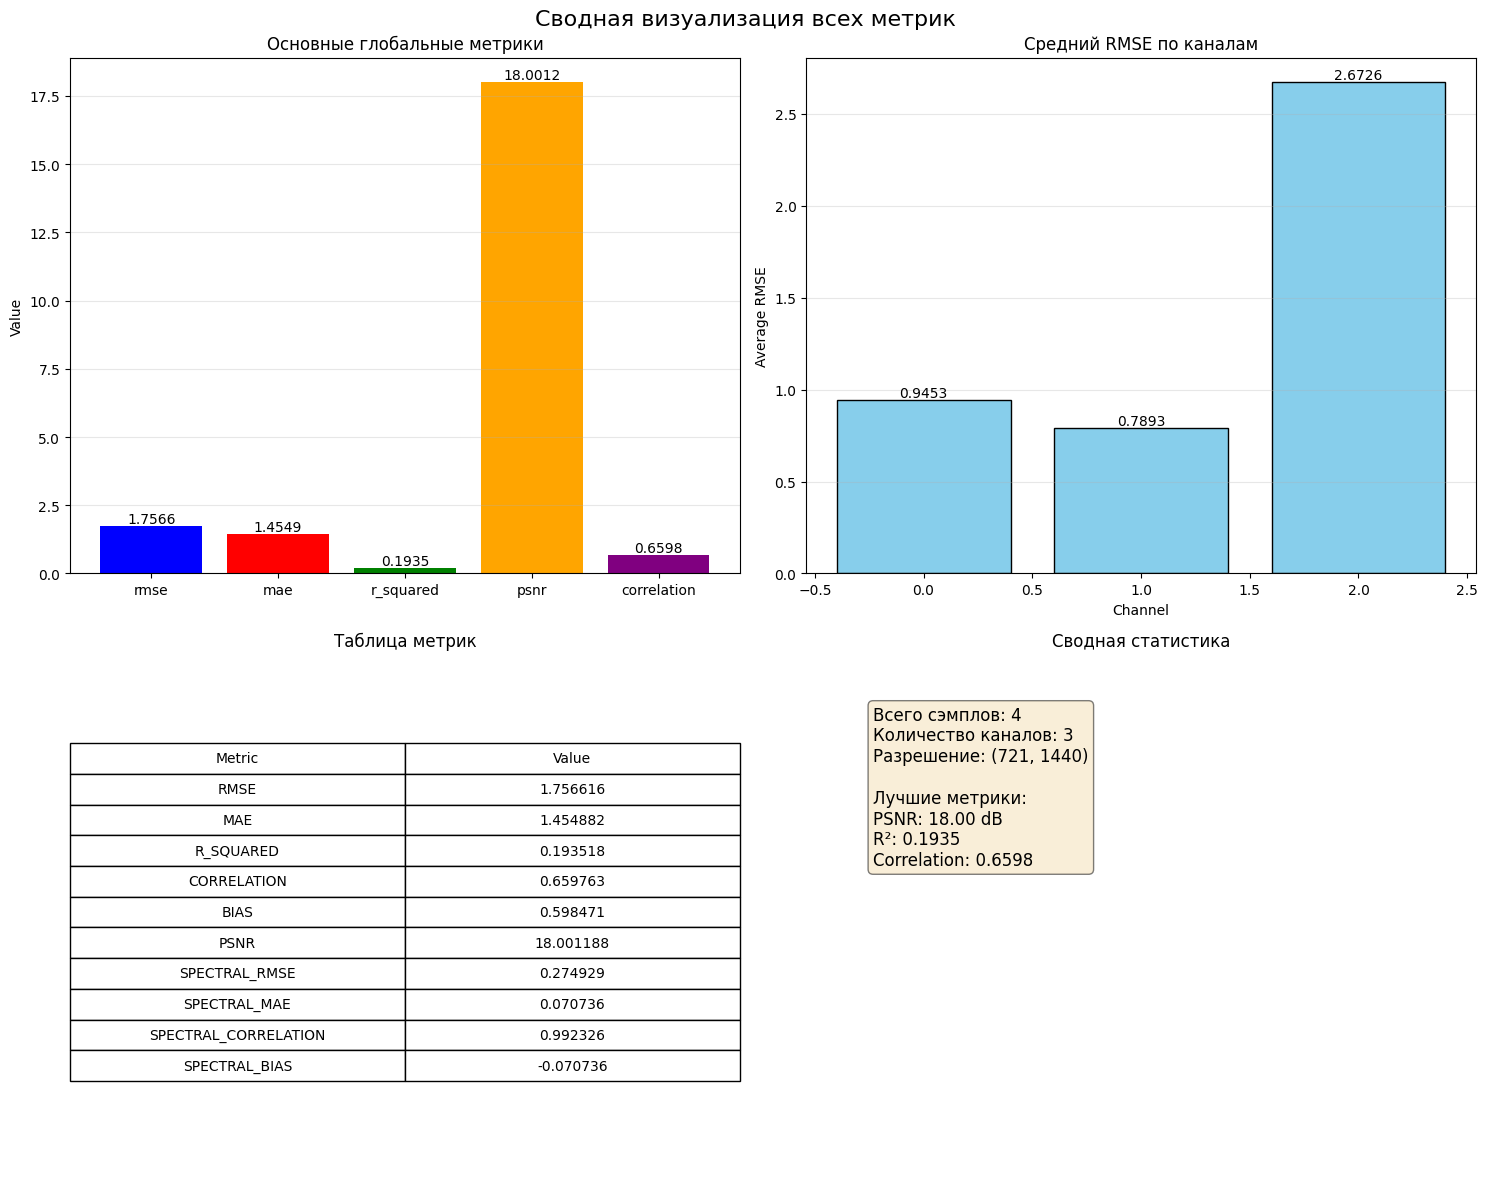


Создание полного отчета...
Полный отчет создан в: test_results/20251207_133222
HTML отчет: test_results/20251207_133222/comprehensive_report.html
Текстовый отчет: test_results/20251207_133222/full_report.txt


In [15]:
config['variables'] = actual_variables
test_results = tester.test_on_dataset(dataloaders['test'], save_zarr=True)